In [1]:
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from base_rl.eval_policy import EvalDiscreteStatePolicy
from dynamic_programming.mdp_model import MDPModel
from dynamic_programming.policy import DPPolicy
from envs.env_creator import env_creator
from envs.plot import plot_industrial_benchmark_trajectories
from rmin.train import RMinTrainer
from experiments.offline_experiment_configs import RMinExperimentConfig

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]
fixed_digits = 6

In [ ]:
# parameters

model_names = ['model_aeq-20bits3']
root_path = 'tmp'
training_episodes = [10, 100, 1000, 10000]
min_count = [1, 2, 3, 5]
total_epochs=500

## Load Data and MDP Model

In [3]:
if len(training_episodes) != len(min_count):
    raise Exception('training_episodes and min_count must be of same length')

trajectory_paths = [os.path.join(root_path, "offline_rl_trajectories", model, "rl_dataset.npy") for model in model_names]
steps_per_episode = 1000


experiment_configs = []
device = 'cpu'
for model_name in model_names:
    for i, training_episode in enumerate(training_episodes):
        experiment_configs.append(
            RMinExperimentConfig(
                model_name=model_name,
                model_path=os.path.join(root_path, 'state_quantization', model_name),
                dataset_path=os.path.join(root_path, "offline_rl_trajectories", model_name, "rl_dataset.npy"),
                mdp_path=os.path.join(root_path, 'rmin', 'mdp', model_name, f'{training_episode}', 'mdp_model.pkl'),
                policy_path=os.path.join(root_path, 'rmin', model_name, f'{training_episode}',
                                         'policy.pkl'),
                dataset_size=training_episode * steps_per_episode,
                r_min=min_count[i]
            )
        )



## Create MDP Models

In [4]:
from dynamic_programming.mdp_model import create_mdp_models

for config in experiment_configs:
    create_mdp_models(load_path=config.dataset_path, mdp_save_path=config.mdp_path, reward_function_type='state_action',
                      device=device, dataset_size=config.dataset_size)

tmp/rmin/mdp/model_aeq-20bits3/10/mdp_model.pkl
-381.6059063415527
10000
1180
Computing Transition Model
Computing Reward Function
tmp/rmin/mdp/model_aeq-20bits3/100/mdp_model.pkl
-349.6023522132111
100000
2426
Computing Transition Model
Computing Reward Function
tmp/rmin/mdp/model_aeq-20bits3/1000/mdp_model.pkl
-344.6461636640358
1000000
3603
Computing Transition Model
Computing Reward Function
tmp/rmin/mdp/model_aeq-20bits3/10000/mdp_model.pkl
-341.13575161187475
10000000
4691
Computing Transition Model
Computing Reward Function


## Train

tmp/rmin/mdp/model_aeq-20bits3/10/mdp_model.pkl
Old vs New policy difference: 842140.1181839642
Old vs New policy difference: 284768.13617337163
Old vs New policy difference: 202679.27189894795
Epoch: 2


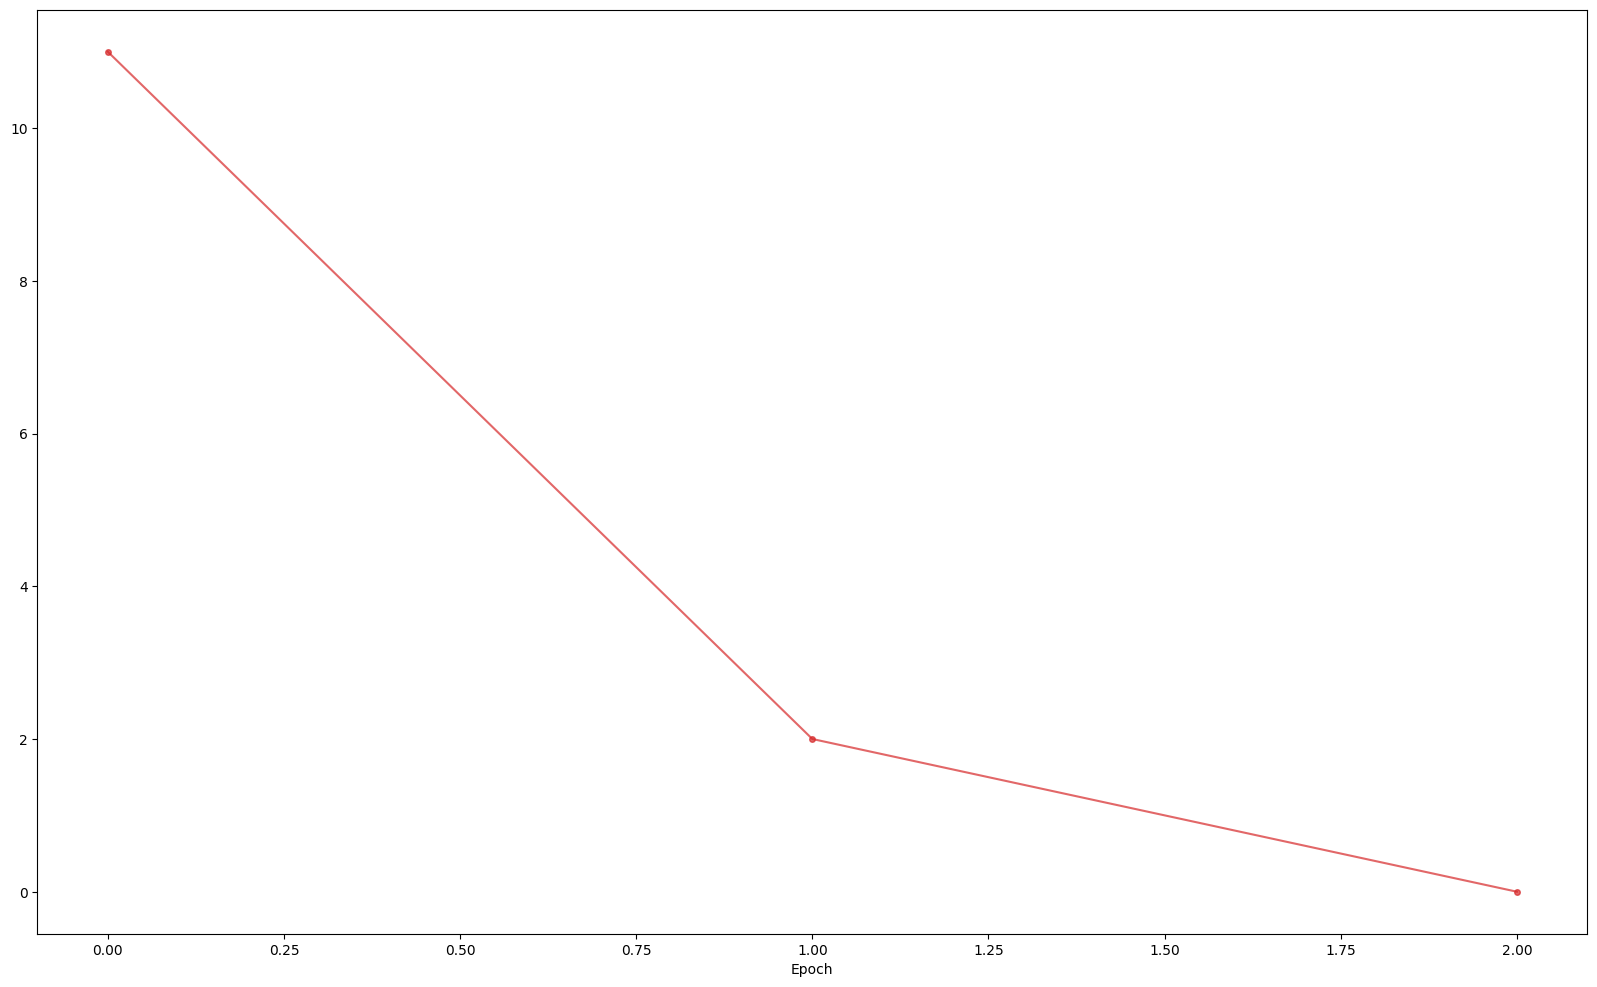

tmp/rmin/mdp/model_aeq-20bits3/100/mdp_model.pkl
Old vs New policy difference: 6200484.2873214595
Old vs New policy difference: 1189133.2235545116
Old vs New policy difference: 692767.8197257849
Old vs New policy difference: 476722.95537497575
Old vs New policy difference: 361832.72503192804
Old vs New policy difference: 288098.79627491307
Old vs New policy difference: 234976.40834396225
Old vs New policy difference: 195971.51159007827
Old vs New policy difference: 165851.27404114197
Old vs New policy difference: 142149.46600462668
Old vs New policy difference: 118667.76834283808
Old vs New policy difference: 91418.01947051991
Old vs New policy difference: 71961.22521532617
Old vs New policy difference: 57424.317995377176
Old vs New policy difference: 47118.28555476913
Old vs New policy difference: 39520.03426735114
Old vs New policy difference: 33769.888825844006
Old vs New policy difference: 29477.789988027933
Old vs New policy difference: 26308.82763019649
Old vs New policy differen

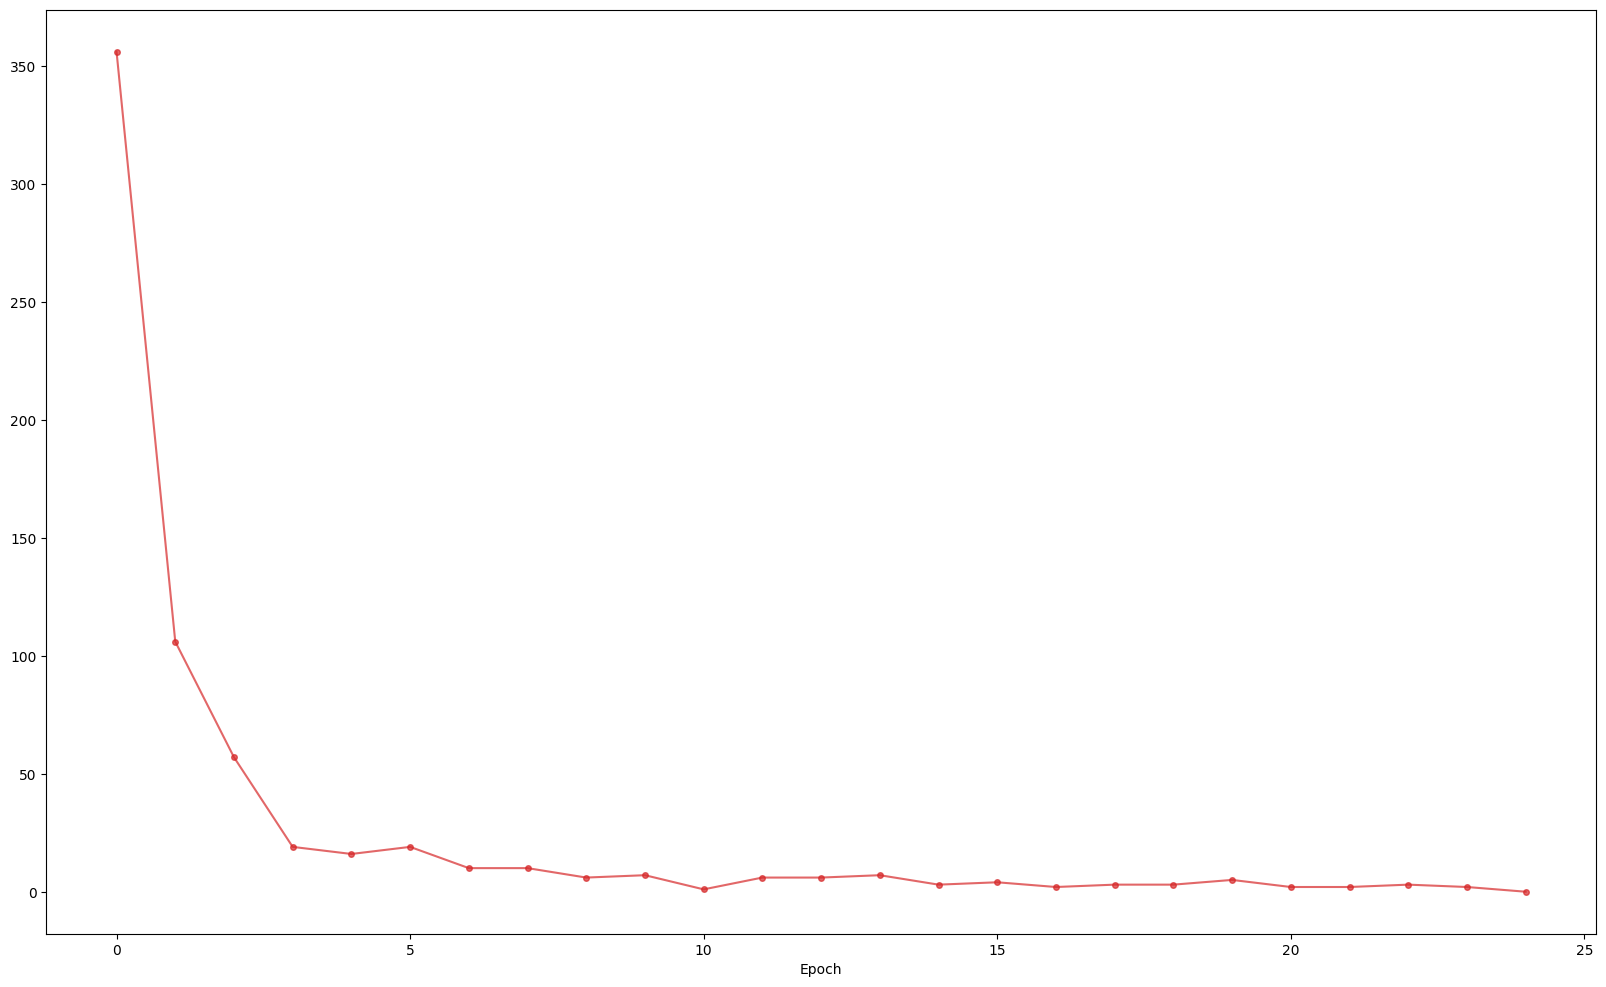

tmp/rmin/mdp/model_aeq-20bits3/1000/mdp_model.pkl
Old vs New policy difference: 6441299.23240979
Old vs New policy difference: 1003992.4234205774
Old vs New policy difference: 437788.3013009525
Old vs New policy difference: 261945.6058610973
Old vs New policy difference: 171427.26144664563
Old vs New policy difference: 128819.95898769642
Old vs New policy difference: 104879.54045499914
Old vs New policy difference: 90987.97961915836
Old vs New policy difference: 81893.08251330742
Old vs New policy difference: 75150.54759942708
Old vs New policy difference: 69700.97792366901
Old vs New policy difference: 65141.97590546542
Old vs New policy difference: 61092.70081762781
Old vs New policy difference: 57497.222520382085
Old vs New policy difference: 54064.54328907259
Old vs New policy difference: 50843.72853705418
Old vs New policy difference: 47884.33310389999
Old vs New policy difference: 45303.56491779113
Old vs New policy difference: 43011.977413370165
Old vs New policy difference: 409

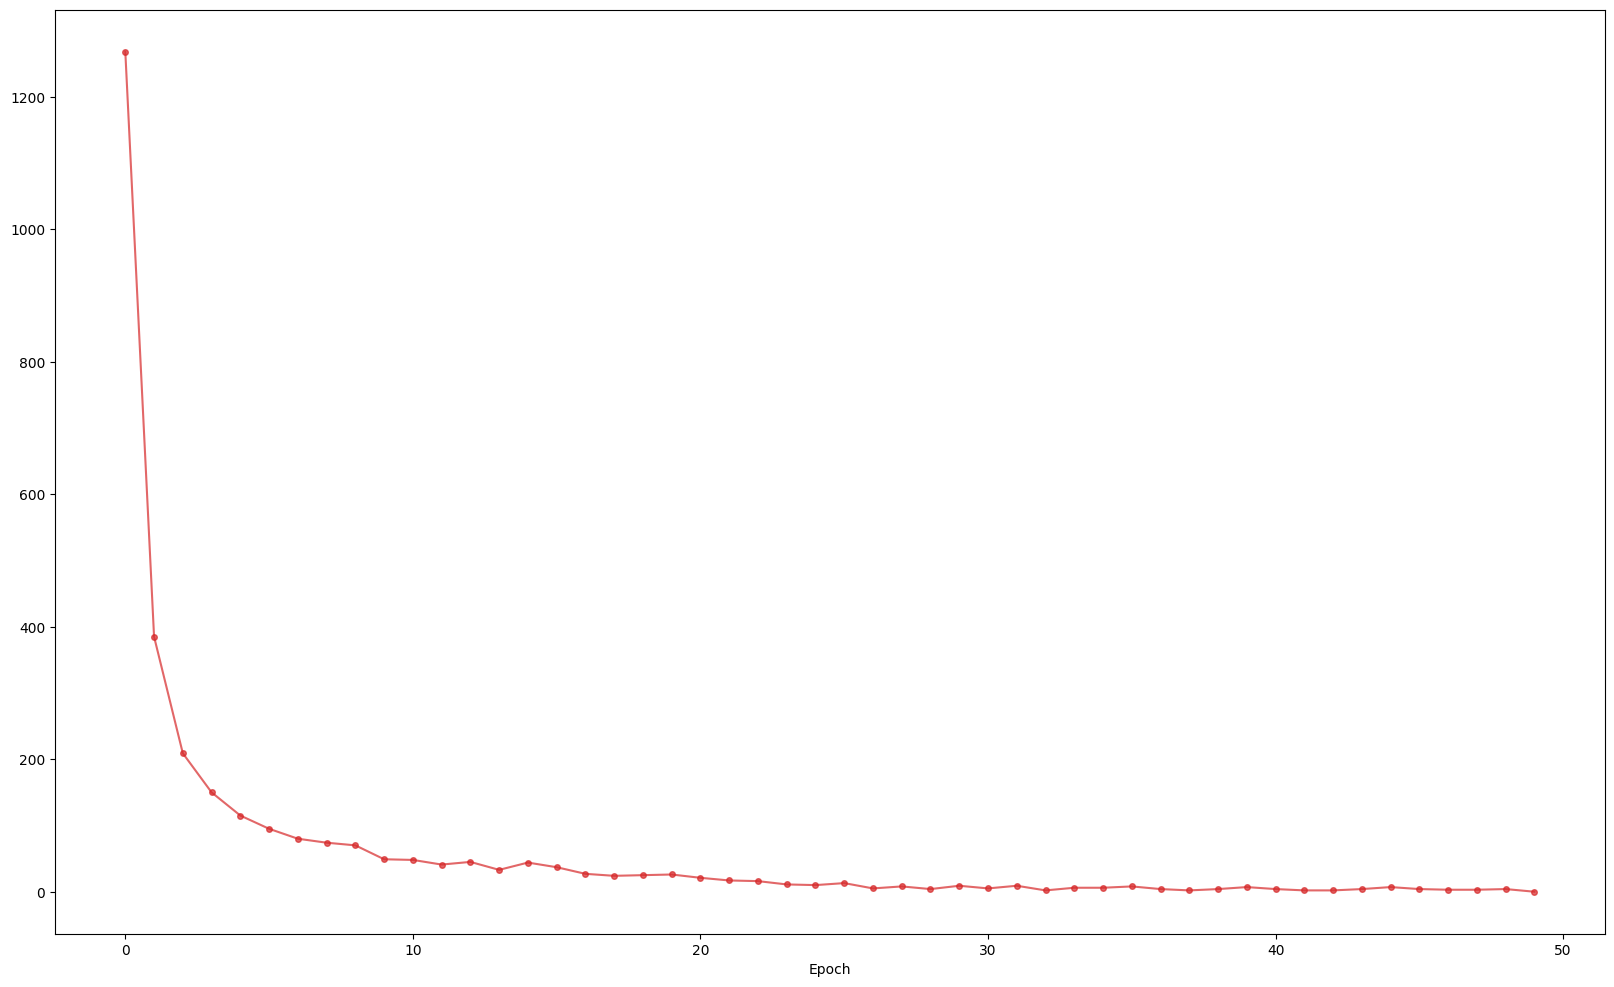

tmp/rmin/mdp/model_aeq-20bits3/10000/mdp_model.pkl
Old vs New policy difference: 5774356.544669567
Old vs New policy difference: 669084.369050636
Old vs New policy difference: 222828.66023863642
Old vs New policy difference: 128068.51577845938
Old vs New policy difference: 97001.64236132003
Old vs New policy difference: 84173.07198659654
Old vs New policy difference: 77580.0165856764
Old vs New policy difference: 73312.04014759278
Old vs New policy difference: 70085.63386145054
Old vs New policy difference: 67445.02065775885
Old vs New policy difference: 65177.285631370454
Old vs New policy difference: 63174.69463988343
Old vs New policy difference: 61404.9857649391
Old vs New policy difference: 59836.881429608235
Old vs New policy difference: 58429.531639753855
Old vs New policy difference: 57175.026227953334
Old vs New policy difference: 56052.563944447225
Old vs New policy difference: 55042.837916578224
Old vs New policy difference: 54116.93174103245
Old vs New policy difference: 53

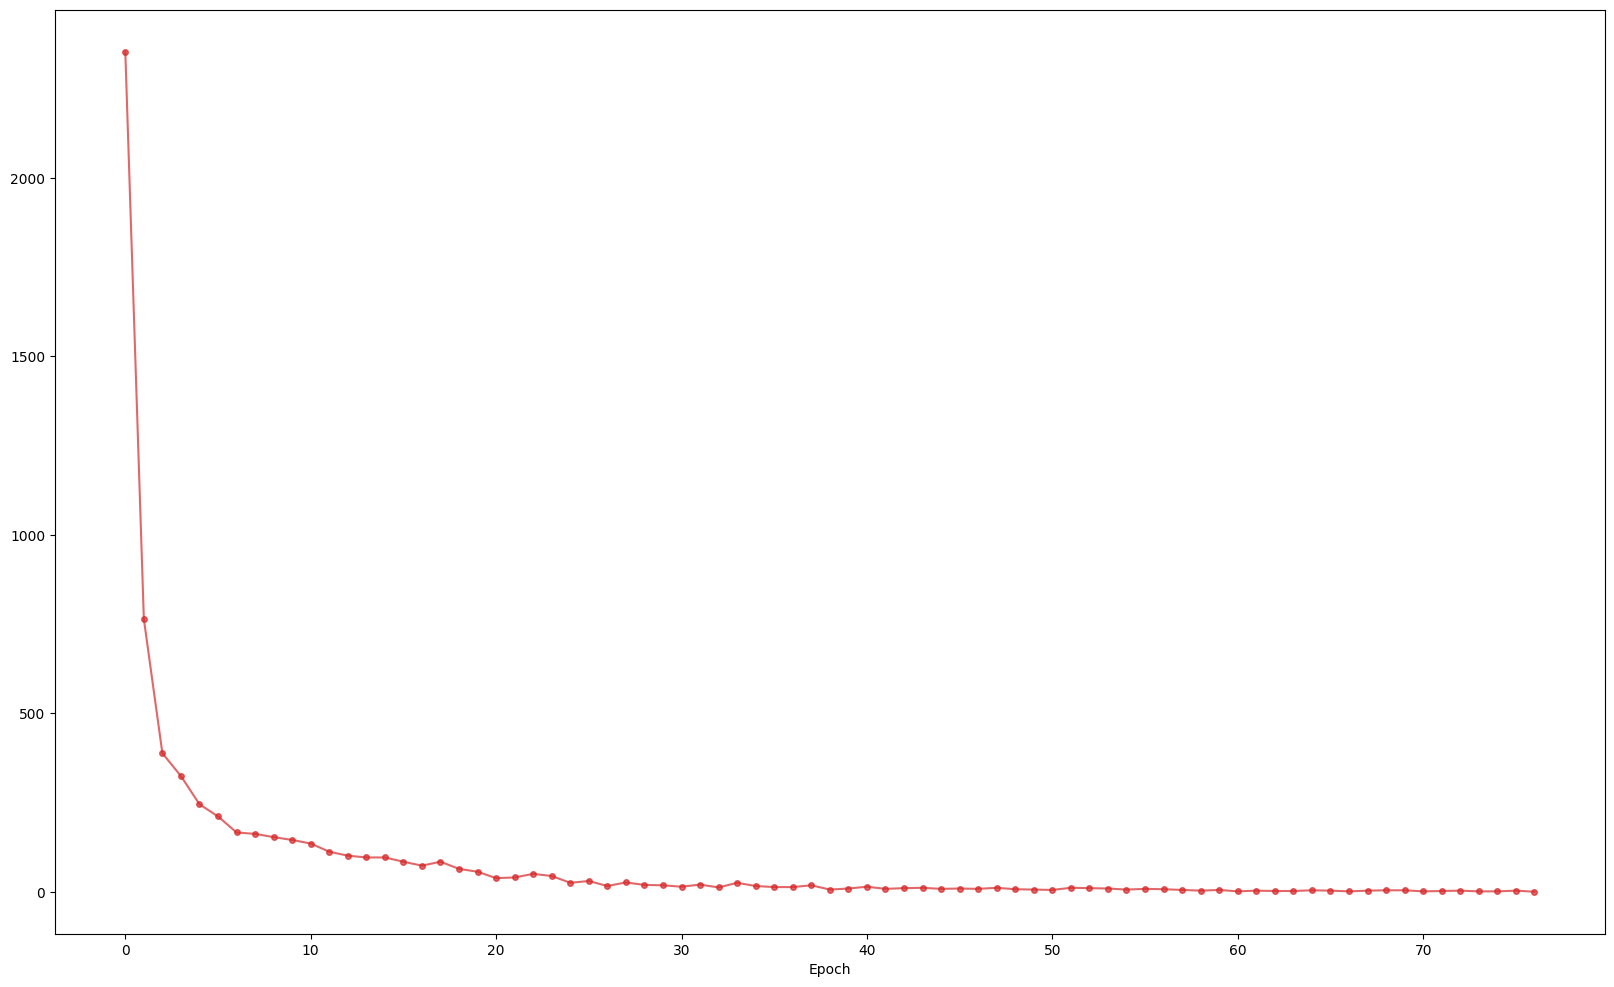

In [5]:
def train_r_min(mdp_path, policy_save_path):
    mdp_model = MDPModel.load(mdp_path)
    solver = RMinTrainer(reward_function=mdp_model.reward_function, transition_model=mdp_model.transition_model,
                         count_state_action=mdp_model.count_state_action, min_count=min_count[i])
    solver.train(epochs=total_epochs, gamma=0.995)
    trained_policy = DPPolicy(policy_table=solver.get_policy(), state_to_index=mdp_model.state_to_index,
                              index_to_action=mdp_model.index_to_actions)
    trained_policy.save(policy_save_path)


for config in experiment_configs:
    print(config.mdp_path)
    train_r_min(mdp_path=config.mdp_path, policy_save_path=config.policy_path)




## Evaluate

Tag: model_aeq-20bits3/10000000
Episode 9 Reward: -192.45916151587258 || New State Found: False


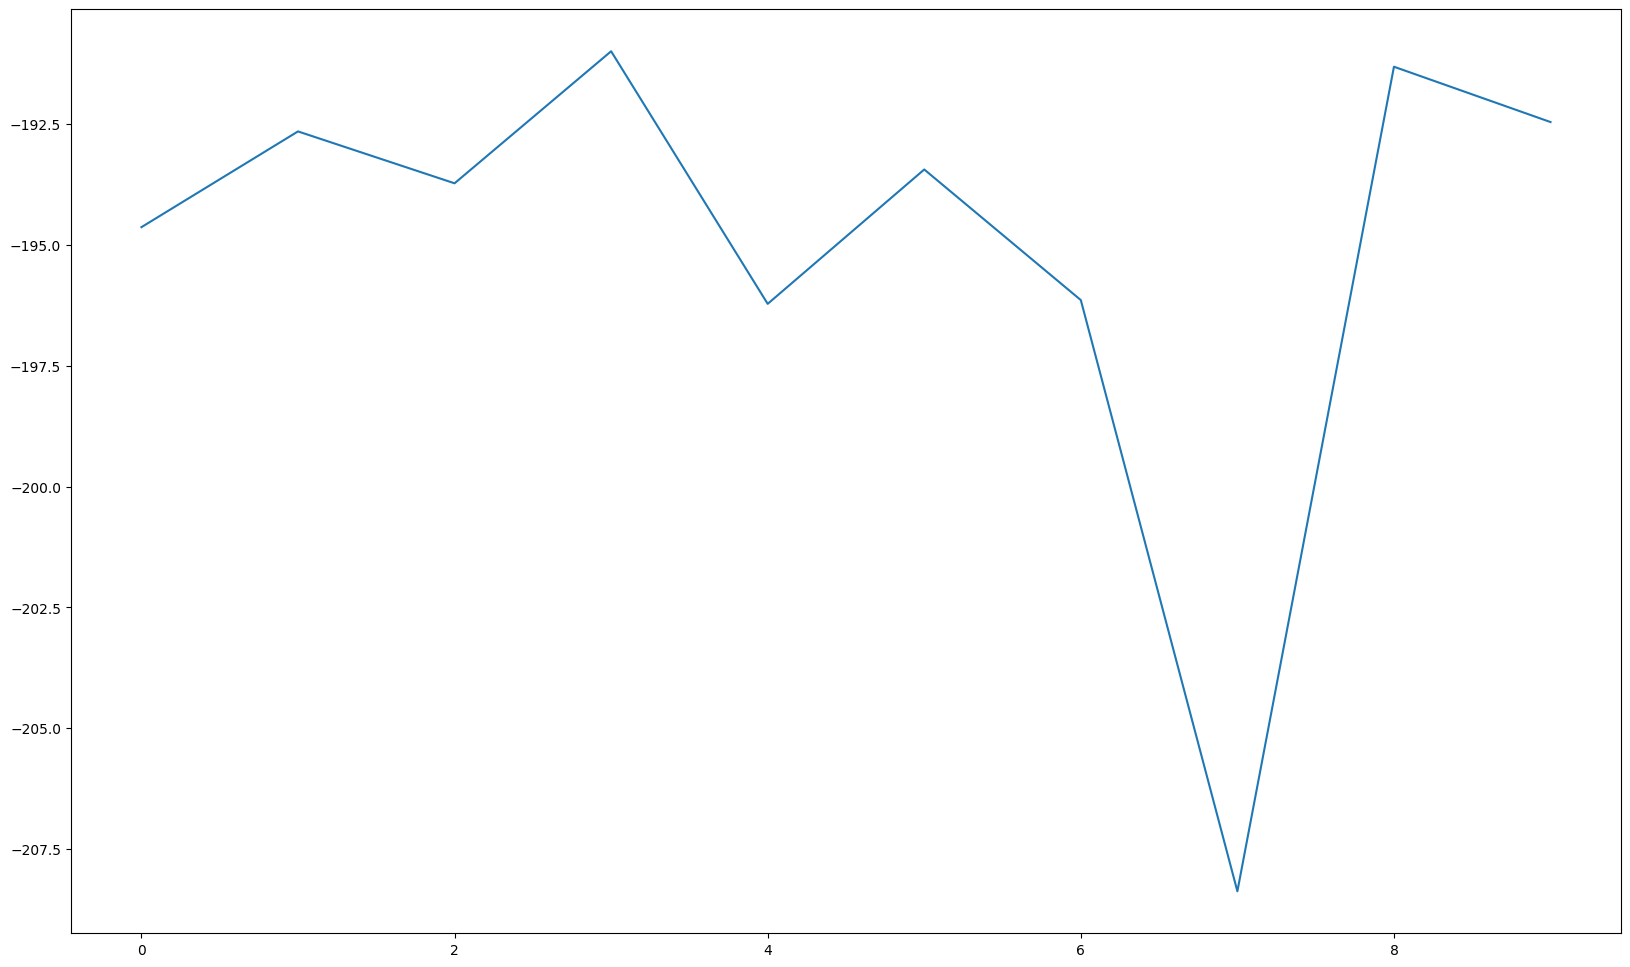

Reward Mean: -194.99567832595366
Reward std : 4.768467776662247


In [6]:
from benchmarks.policy_benchmarks import PolicyBenchmarks

steps_per_episode = 1000
evaluators = []
for config in experiment_configs:
    print(config.__dict__)
    eval_policy = DPPolicy.load(config.policy_path)
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device, 'model_path': config.model_path}
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=env_kwargs,
                                        tag=f'{config.model_name}/{config.dataset_size}')
    evaluators.append(evaluator)

policy_benchmarks = PolicyBenchmarks(evaluators=evaluators, epochs=10)
policy_benchmarks.benchmark()

-216.2201360846368

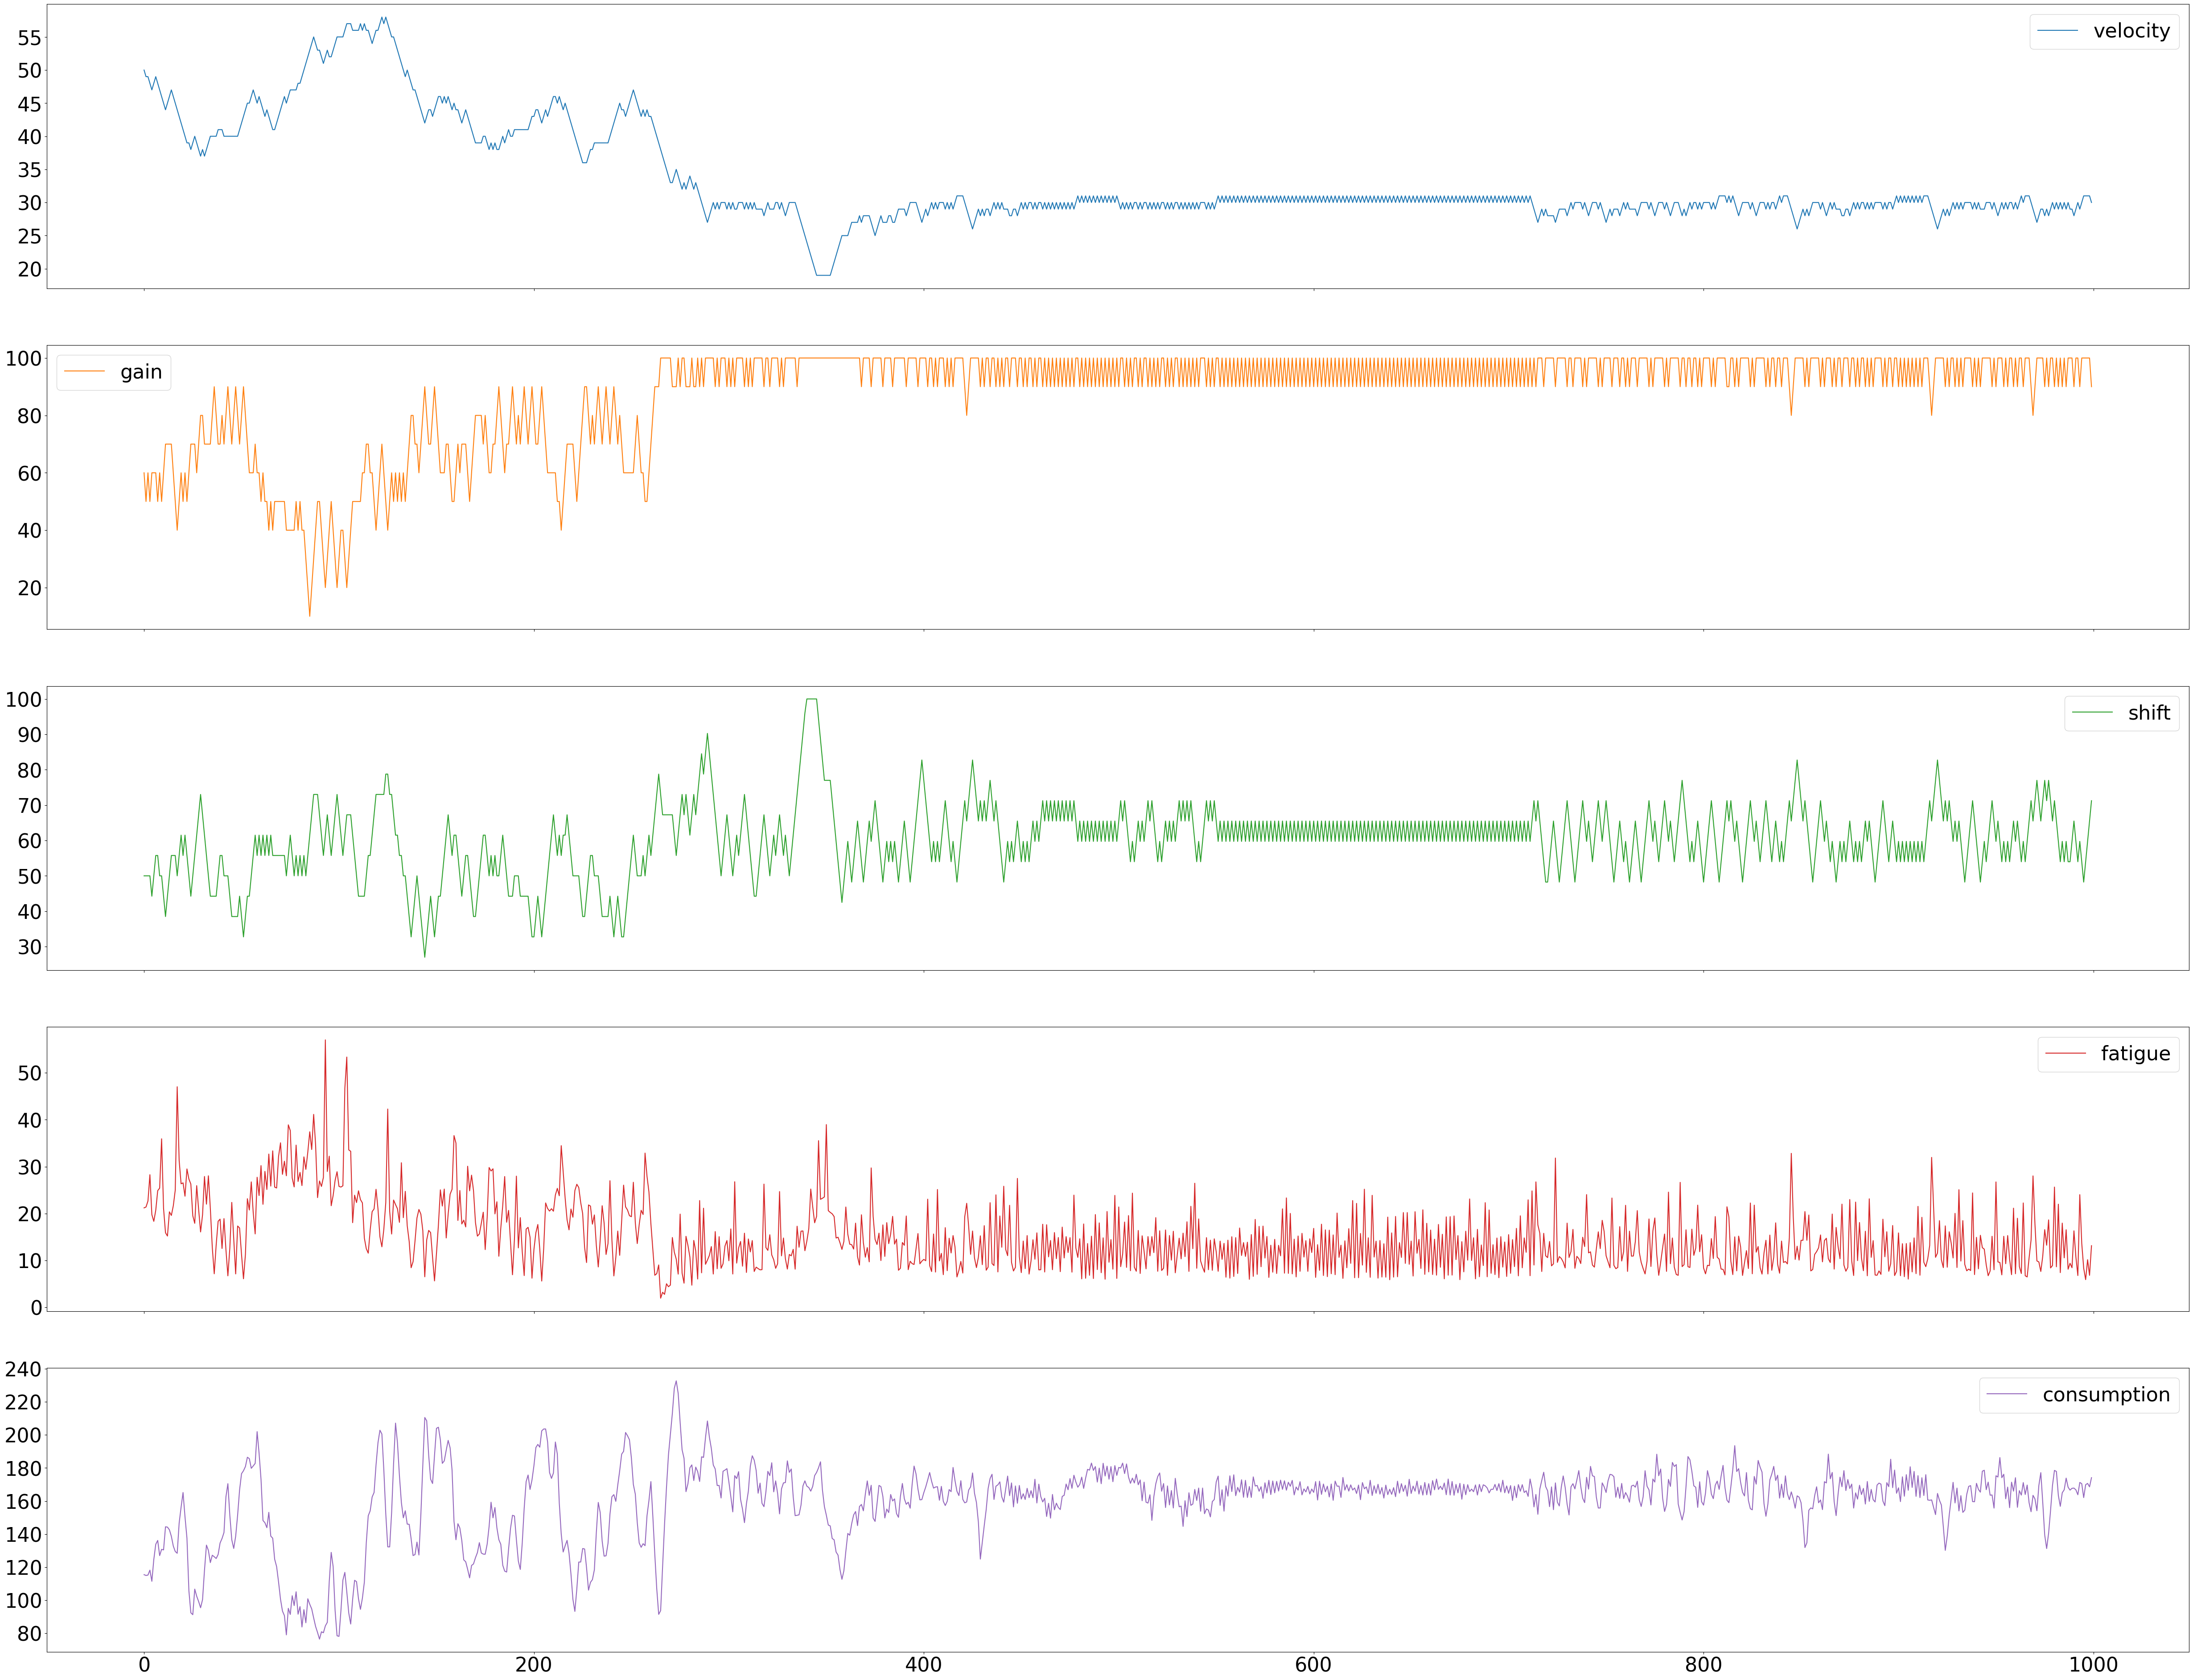

In [7]:
plot_industrial_benchmark_trajectories(policy_benchmarks.evaluators[-2].eval_trajectories[0]['info'])
np.mean(policy_benchmarks.evaluators[-2].eval_rewards_per_epoch)

In [8]:
df = pd.DataFrame(policy_benchmarks.benchmark_metrics)
df.T

,reward,std,unique_obs
model_aeq-20bits3/10000,-574.723036,52.642598,296.0
model_aeq-20bits3/100000,-606.636312,251.595919,208.0
model_aeq-20bits3/1000000,-216.220136,17.707838,244.0
model_aeq-20bits3/10000000,-194.995678,4.768468,89.0


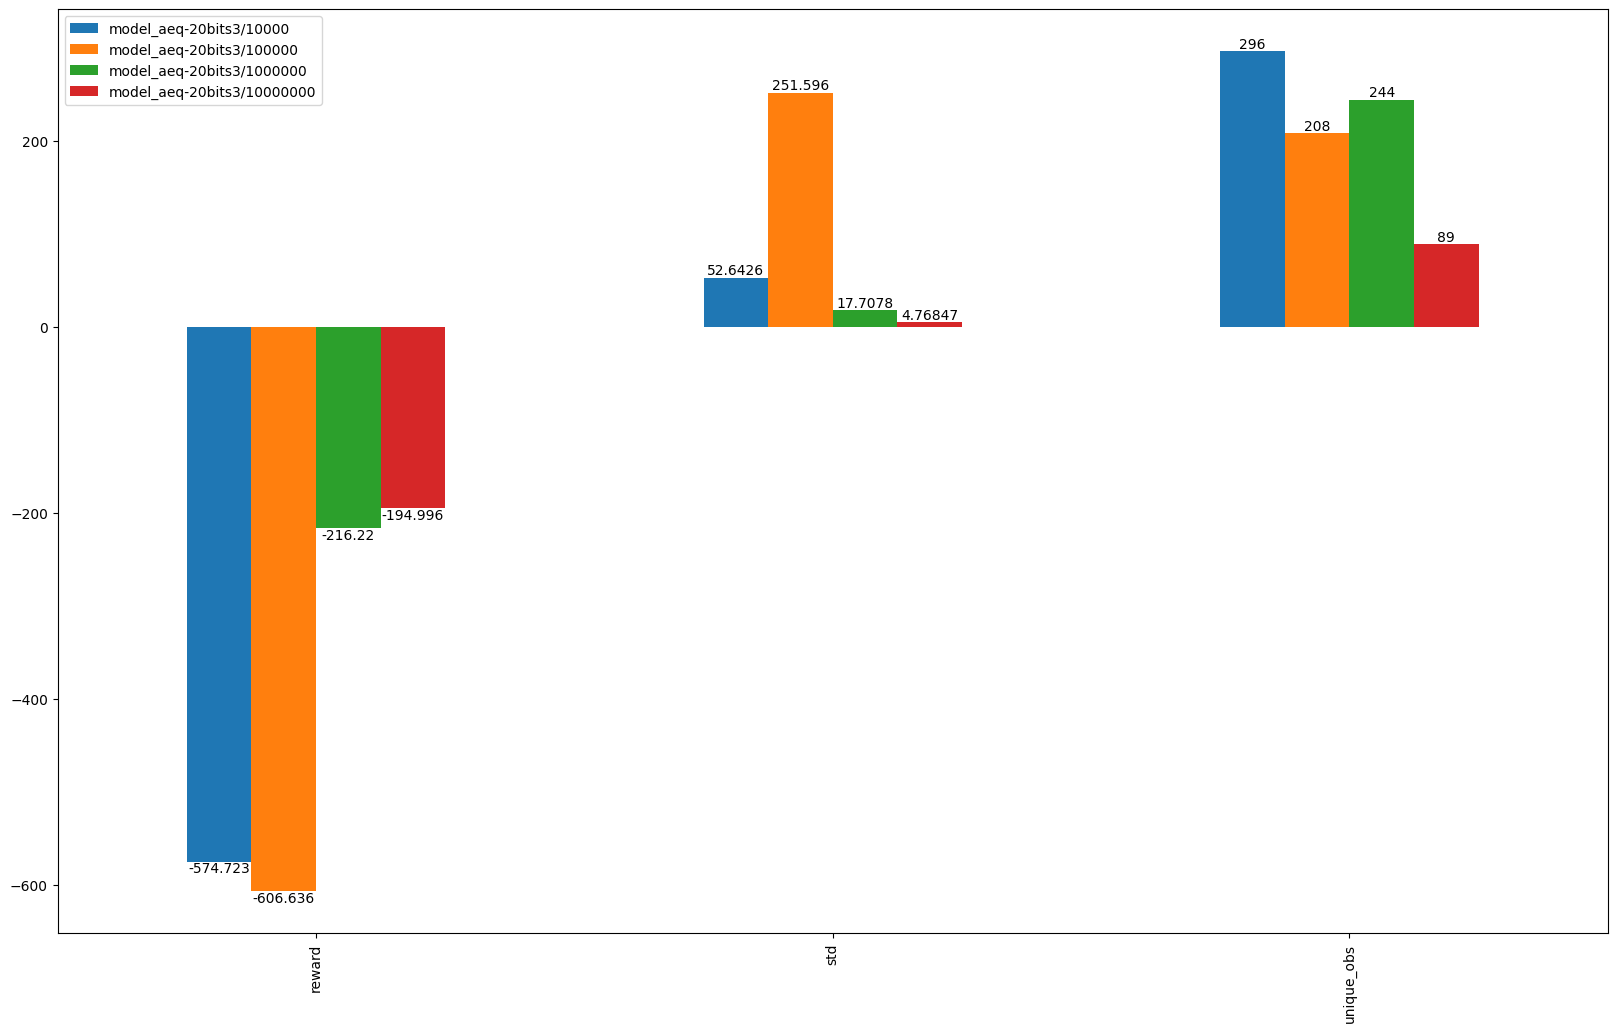

In [9]:
plt.rcParams["figure.figsize"] = [20, 12]


for model_name in model_names:
    m = np.core.defchararray.find(df.columns.values.astype(str), model_name) >= 0
    fdf = df.loc[:, m]
    ax = fdf.plot.bar()

    for container in ax.containers:
        ax.bar_label(container)
    plt.show()